In [10]:
from transformers import AutoTokenizer, AutoModel, DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import get_scheduler


ckpt_path = "jhgan/ko-sbert-sts"
sbert_tokenizer = AutoTokenizer.from_pretrained(ckpt_path)
sbert_model = AutoModelForSequenceClassification.from_pretrained(ckpt_path, num_labels=9)

training_args = TrainingArguments("test-trainer")

torch.cuda.empty_cache()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at jhgan/ko-sbert-sts and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
class contentDataset(Dataset):
    def __init__(self, file, tok, max_len, pad_index=None):
        super().__init__()
        self.tok =tok
        self.max_len = max_len
        self.content = pd.read_csv(file)
        self.len = self.content.shape[0]
        self.pad_index = self.tok.pad_token
    
    def add_padding_data(self, inputs, max_len):
        if len(inputs) < max_len:
            # pad = np.array([self.pad_index] * (max_len - len(inputs)))
            pad = np.array([0] * (max_len - len(inputs)))
            inputs = np.concatenate([inputs, pad])
            return inputs
        else:
            inputs = inputs[:max_len]
            return inputs
    
    def __getitem__(self,idx):
        instance = self.content.iloc[idx]
        # text = "[CLS]" + instance['content'] + "[SEP]"
        text = instance['text']
        input_ids = self.tok.encode(text)
        
        input_ids = self.add_padding_data(input_ids, max_len=self.max_len)
        label_ids = instance['label']
        # encoder_attention_mask = input_ids.ne(0).float()
        return {"encoder_input_ids" : np.array(input_ids, dtype=np.int_),
                "label" : np.array(label_ids,dtype=np.int_)}
        
    def __len__(self):
        return self.len

In [12]:
dataset = pd.read_csv('/home/keonwoo/anaconda3/envs/bgmRS/data/labeled_data_0706.csv')
dataset.drop(['Unnamed: 0'],axis=1,inplace=True)

dataset['label'] = pd.factorize(dataset['label'])[0]
# dataset.columns = ['label','text']
dataset = dataset.sample(frac=1).reset_index(drop=True)


train_num = int(len(dataset)*0.9)
trainset = dataset.iloc[:train_num]
validset = dataset.iloc[train_num:]

trainset.to_csv('/home/keonwoo/anaconda3/envs/bgmRS/data/trainset.csv')
validset.to_csv('/home/keonwoo/anaconda3/envs/bgmRS/data/validset.csv')

train_setup = contentDataset(file = "/home/keonwoo/anaconda3/envs/bgmRS/data/trainset.csv",tok = sbert_tokenizer, max_len = 512)
valid_setup = contentDataset(file = "/home/keonwoo/anaconda3/envs/bgmRS/data/validset.csv",tok = sbert_tokenizer, max_len = 512)


tarin_dataloader = DataLoader(train_setup, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(valid_setup, batch_size=32, shuffle=False)

optimizer = AdamW(sbert_model.parameters(), lr=5e-5)


num_epochs = 5
num_training_steps = num_epochs * len(tarin_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

In [13]:
from torch.nn.parallel import DistributedDataParallel

n_gpus = torch.cuda.device_count()


device = torch.device("cuda:2") if torch.cuda.is_available() else torch.device("cpu")
sbert_model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

### Training

In [14]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))
loss_list = []

sbert_model.train()
for epoch in range(num_epochs):
    for batch in tarin_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        encoder_attention_mask = batch["encoder_input_ids"].ne(0).float().to(device)
        outputs = sbert_model(batch['encoder_input_ids'], attention_mask=encoder_attention_mask, labels=batch['label'])
        loss = outputs.loss
        loss_list.append(loss.item())
        
        loss.backward()
        
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

  0%|          | 0/940 [00:23<?, ?it/s]


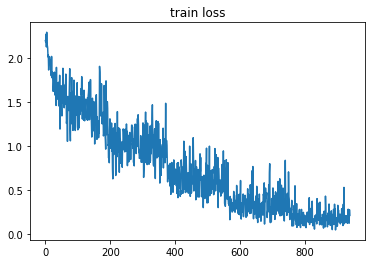

In [15]:
from matplotlib import pyplot as plt

plt.plot(loss_list)
plt.title('train loss')
plt.show()

In [16]:
sbert_model.save_pretrained("/home/keonwoo/anaconda3/envs/bgmRS/ckpt/sbert_0706")

In [17]:
device = torch.device("cuda:2") if torch.cuda.is_available() else torch.device("cpu")

model = AutoModelForSequenceClassification.from_pretrained("/home/keonwoo/anaconda3/envs/bgmRS/ckpt/sbert_0706", num_labels=9)
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

### Validset Evaluation

In [18]:
from tqdm.auto import tqdm
from datasets import load_metric

pred = []
ref = []

model.eval()
for batch in valid_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    encoder_attention_mask = batch["encoder_input_ids"].ne(0).float().to(device)
    with torch.no_grad():
        outputs = model(batch['encoder_input_ids'], attention_mask=encoder_attention_mask, labels=batch['label'])
        
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    pred.append(predictions)
    ref.append(batch['label'])

pred = torch.cat(pred, 0)
ref = torch.cat(ref, 0)

In [19]:
acc = load_metric("accuracy")
recall = load_metric("recall")
f1 = load_metric("f1")
prec = load_metric("precision")


acc.compute(predictions=pred, references=ref)

{'accuracy': 0.6002994011976048}

In [20]:
prec.compute(predictions=pred, references=ref, average="weighted")

{'precision': 0.6205042316771254}

In [21]:
recall.compute(predictions=pred, references=ref, average="weighted")

{'recall': 0.6002994011976048}

In [22]:
f1.compute(predictions=pred, references=ref, average="weighted")

{'f1': 0.6056715600424968}

In [23]:
validset['pred'] = pred.detach().cpu().numpy()

/tmp/ipykernel_41957/2334514741.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validset['pred'] = pred.detach().cpu().numpy()


In [24]:
label_dict = {
    '희망적인' : 0,  # 소분류
    '감동적인' : 1, # 소분류
    '무서운' : 2,  # 불안 -> 소분류
    '로맨틱한' : 3, # 소분류
    '평화로운' : 4, # 소분류
    '멋진' : 5, # 소분류
    '우스운' : 6, # 소분류
    '신나는' : 7, # 소분류
    '쿨한' : 8 # 소분류
}

reversed_dict = dict(map(reversed, label_dict.items()))

def change_label(x):
    return reversed_dict[x]

validset['Actual Label'] = validset['label'].apply(lambda x: change_label(x))
validset['Pred Label'] = validset['pred'].apply(lambda x: change_label(x))
validset.drop(['label','pred'],axis=1,inplace=True)

validset.to_csv('tmp_snu_added_0706__bad.csv')

/tmp/ipykernel_41957/1985121609.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validset['Actual Label'] = validset['label'].apply(lambda x: change_label(x))
/tmp/ipykernel_41957/1985121609.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validset['Pred Label'] = validset['pred'].apply(lambda x: change_label(x))
/tmp/ipykernel_41957/1985121609.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydat

In [25]:
import pandas as pd

data = pd.read_csv('tmp_snu_added_0706__bad.csv')
data.drop(['Unnamed: 0'],axis=1,inplace=True)
data.head()

,text,Actual Label,Pred Label
0,딸 대학 발표를 기다리며 긴장이 되는군요.,쿨한,쿨한
1,애인과 부모님과의 관계 모두 잘 이루어 나가시길 바라요.,희망적인,희망적인
2,아빠랑 있을 때 편안한 기분이 드시겠어요. 다른 좋은 점도 있으신가요?,로맨틱한,감동적인
3,집에 들어가기 싫을 무슨 일이 있으셨나요?,무서운,우스운
4,오랜 작업에 대한 습관보다 배운다는 생각으로 업무를 해서 잘 적응했으면 좋겠어요.,로맨틱한,로맨틱한


In [26]:
not_correct = []
for i in range(len(data)):
    if data.iloc[i]['Actual Label'] != data.iloc[i]['Pred Label']:
        not_correct.append(i)

In [27]:
data.iloc[not_correct].tail(30)

,text,Actual Label,Pred Label
598,그 선배는 나를 이유 없이 항상 괴롭혔어. 그래도 이젠 해방되었어!,평화로운,희망적인
601,피로가 많이 쌓이셨군요.,감동적인,쿨한
602,앞으로 어떻게 하고 싶으신가요?,멋진,신나는
603,막내가 사춘기라서 신경질적이었는데 요즘 들어서 좋아진 것 같아서 다행이야.,희망적인,평화로운
605,항상 건강하시길 바랄게요.,멋진,평화로운
606,또 한 해가 지나가겠지.,감동적인,로맨틱한
608,한편으론 앞으로 계속 좋은 인상을 유지하는 것은 배로 힘들 것 같아.,로맨틱한,평화로운
616,시어머님을 모시고 가족들과 한 시간 거리 이내로라도 여행을 다녀와야지.,쿨한,감동적인
619,귀찮긴 하지만 행복하단 감정도 드시는군요,무서운,로맨틱한
620,앞으로도 밀리지 않고 저축하려면 어떻게 해야 할까요?,감동적인,신나는
